In [2]:
import pandas as pd

In [3]:

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url)

In [4]:

data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
data = pd.concat([data]*4, ignore_index=True)
print(len(data))


576


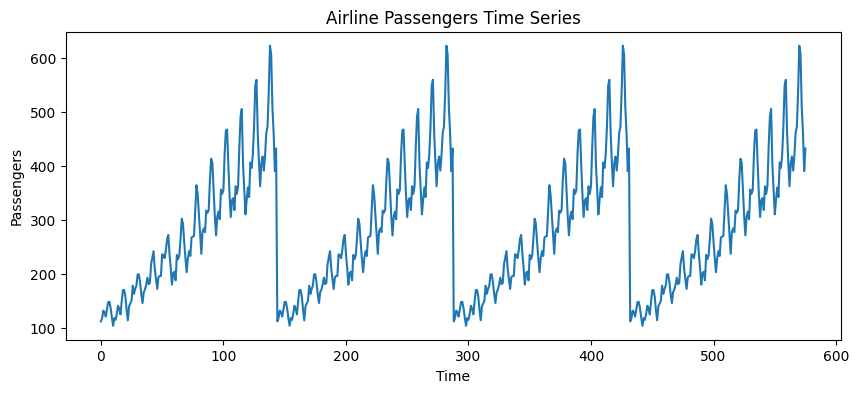

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(data["Passengers"])
plt.title("Airline Passengers Time Series")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.show()


In [7]:
import numpy as np

values = data["Passengers"].values.reshape(-1, 1)
values.shape


(576, 1)

In [8]:
train_size = int(len(values) * 0.7)
val_size = int(len(values) * 0.15)

train = values[:train_size]
val = values[train_size:train_size + val_size]
test = values[train_size + val_size:]

len(train), len(val), len(test)


(403, 86, 87)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)


In [10]:
def create_sequences(data, lookback=30, horizon=5):
    X, y = [], []
    for i in range(len(data) - lookback - horizon):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon])
    return np.array(X), np.array(y)


In [11]:
LOOKBACK = 30
HORIZON = 5

X_train, y_train = create_sequences(train_scaled, LOOKBACK, HORIZON)
X_val, y_val = create_sequences(val_scaled, LOOKBACK, HORIZON)
X_test, y_test = create_sequences(test_scaled, LOOKBACK, HORIZON)

X_train.shape, y_train.shape


((368, 30, 1), (368, 5, 1))

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [14]:
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)


In [15]:
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=32,
    shuffle=False
)


In [16]:
class LSTMBaseline(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=5):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]          # last time step
        out = self.fc(out)
        return out.unsqueeze(-1)     # (batch, horizon, 1)


In [17]:
model = LSTMBaseline(output_size=HORIZON).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            val_loss += criterion(preds, yb).item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/20 | Train Loss: 1.5347 | Val Loss: 0.0190
Epoch 2/20 | Train Loss: 0.8016 | Val Loss: 0.1417
Epoch 3/20 | Train Loss: 0.5303 | Val Loss: 0.0403
Epoch 4/20 | Train Loss: 0.4452 | Val Loss: 0.0826
Epoch 5/20 | Train Loss: 0.4207 | Val Loss: 0.0603
Epoch 6/20 | Train Loss: 0.3883 | Val Loss: 0.0590
Epoch 7/20 | Train Loss: 0.3452 | Val Loss: 0.0459
Epoch 8/20 | Train Loss: 0.3430 | Val Loss: 0.0329
Epoch 9/20 | Train Loss: 0.3088 | Val Loss: 0.0470
Epoch 10/20 | Train Loss: 0.3287 | Val Loss: 0.0499
Epoch 11/20 | Train Loss: 0.3156 | Val Loss: 0.0440
Epoch 12/20 | Train Loss: 0.2835 | Val Loss: 0.0269
Epoch 13/20 | Train Loss: 0.2835 | Val Loss: 0.0218
Epoch 14/20 | Train Loss: 0.2752 | Val Loss: 0.0268
Epoch 15/20 | Train Loss: 0.2622 | Val Loss: 0.0409
Epoch 16/20 | Train Loss: 0.2803 | Val Loss: 0.0250
Epoch 17/20 | Train Loss: 0.2689 | Val Loss: 0.0185
Epoch 18/20 | Train Loss: 0.2496 | Val Loss: 0.0204
Epoch 19/20 | Train Loss: 0.2479 | Val Loss: 0.0189
Epoch 20/20 | Train L

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

model.eval()
with torch.no_grad():
    baseline_preds = model(X_test_t).cpu().numpy()
    baseline_true = y_test_t.cpu().numpy()

# reshape
baseline_preds = baseline_preds.reshape(-1)
baseline_true = baseline_true.reshape(-1)

rmse_baseline = np.sqrt(mean_squared_error(baseline_true, baseline_preds))
mae_baseline = mean_absolute_error(baseline_true, baseline_preds)
mape_baseline = np.mean(np.abs((baseline_true - baseline_preds) / baseline_true)) * 100

rmse_baseline, mae_baseline, mape_baseline


(np.float64(0.16378894774971747), 0.12389083206653595, np.float32(19.914747))

In [19]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)

    def forward(self, decoder_hidden, encoder_outputs):
        scores = torch.bmm(
            encoder_outputs,
            decoder_hidden.unsqueeze(2)
        ).squeeze(2)

        weights = torch.softmax(scores, dim=1)
        context = torch.bmm(weights.unsqueeze(1), encoder_outputs)
        return context.squeeze(1)


In [20]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, horizon=5):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.attention = LuongAttention(hidden_size)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.horizon = horizon

    def forward(self, x):
        encoder_outputs, (h, c) = self.encoder(x)

        decoder_input = x[:, -1:, :]
        outputs = []

        for _ in range(self.horizon):
            dec_out, (h, c) = self.decoder(decoder_input, (h, c))
            context = self.attention(h[-1], encoder_outputs)
            combined = torch.cat((dec_out.squeeze(1), context), dim=1)
            pred = self.fc(combined)
            outputs.append(pred.unsqueeze(1))
            decoder_input = pred.unsqueeze(1)

        return torch.cat(outputs, dim=1)


In [21]:
attn_model = Seq2SeqAttention(horizon=HORIZON).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(attn_model.parameters(), lr=0.001)

EPOCHS = 25

for epoch in range(EPOCHS):
    attn_model.train()
    train_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = attn_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f}")


Epoch 1/25 | Train Loss: 0.9796
Epoch 2/25 | Train Loss: 0.5593
Epoch 3/25 | Train Loss: 0.5178
Epoch 4/25 | Train Loss: 0.5059
Epoch 5/25 | Train Loss: 0.4614
Epoch 6/25 | Train Loss: 0.4273
Epoch 7/25 | Train Loss: 0.3680
Epoch 8/25 | Train Loss: 0.3239
Epoch 9/25 | Train Loss: 0.3101
Epoch 10/25 | Train Loss: 0.3163
Epoch 11/25 | Train Loss: 0.2901
Epoch 12/25 | Train Loss: 0.2788
Epoch 13/25 | Train Loss: 0.2483
Epoch 14/25 | Train Loss: 0.2332
Epoch 15/25 | Train Loss: 0.2256
Epoch 16/25 | Train Loss: 0.2218
Epoch 17/25 | Train Loss: 0.2294
Epoch 18/25 | Train Loss: 0.2293
Epoch 19/25 | Train Loss: 0.2265
Epoch 20/25 | Train Loss: 0.2162
Epoch 21/25 | Train Loss: 0.2224
Epoch 22/25 | Train Loss: 0.2166
Epoch 23/25 | Train Loss: 0.2107
Epoch 24/25 | Train Loss: 0.2169
Epoch 25/25 | Train Loss: 0.2076


In [22]:
attn_model.eval()
with torch.no_grad():
    attn_preds = attn_model(X_test_t).cpu().numpy()
    attn_true = y_test_t.cpu().numpy()

attn_preds = attn_preds.reshape(-1)
attn_true = attn_true.reshape(-1)

rmse_attn = np.sqrt(mean_squared_error(attn_true, attn_preds))
mae_attn = mean_absolute_error(attn_true, attn_preds)
mape_attn = np.mean(np.abs((attn_true - attn_preds) / attn_true)) * 100

rmse_attn, mae_attn, mape_attn


(np.float64(0.16054313729569095), 0.1235356554389, np.float32(20.196627))

In [23]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["LSTM Baseline", "Seq2Seq + Attention"],
    "RMSE": [rmse_baseline, rmse_attn],
    "MAE": [mae_baseline, mae_attn],
    "MAPE": [mape_baseline, mape_attn]
})

results


,Model,RMSE,MAE,MAPE
0,LSTM Baseline,0.163789,0.123891,19.914747
1,Seq2Seq + Attention,0.160543,0.123536,20.196627
